Finding basic level categoies
================

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as pltColors
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cosine
import csv
from collections import Counter, defaultdict
from sklearn.preprocessing import normalize
from numpy.linalg import norm
from numpy.linalg import pinv
from scipy.stats import linregress
import scipy.io as sio
from math import log
from scipy.stats import entropy
from sklearn.preprocessing import scale
log2 = lambda x: log(x, 2)
lstDiv = lambda x, y: [a / b for a, b in zip(x, y)]

In [14]:
# Load files
inputFile = 'data/cat_desc.csv'
headers = None
descCnt = Counter()
catCnt = Counter()
descCatCnt = defaultdict(Counter)
with open(inputFile) as fin:
    r = csv.reader(fin)
    for row in r:
        if headers is None:
            headers = row
            print headers
        else:
            cat, desc, cnt = row
            cat = int(cat) - 1
            cnt = int(cnt)
            descCnt[desc] += cnt
            catCnt[cat] += cnt
            descCatCnt[desc][cat] += cnt

catNameFile = 'data/categoryKey.csv'
catName = {}
with open(catNameFile) as fin:
    r = csv.reader(fin)
    for row in r:
        catName[int(row[0]) - 1] = row[1]

print range(len(catName)) == catName.keys() and range(len(catName)) == catCnt.keys()

simMtxGTFile = 'data/largeSimMatrix.mat'
simMtxGT = sio.loadmat(simMtxGTFile)['largeSimMatrix']
print simMtxGT.shape

wordFreq = Counter()
wordFreqSum = -1
with open('data/wikipedia_wordfreq.txt') as fin:
    skipLine = 1 # Skipping first line
    for line in fin:
        line = line.strip()
        if skipLine > 0:
            skipLine -= 1
            wordFreqSum = int(line.strip().split('\t')[1])
            print line
            print wordFreqSum
        else:
            w, c = line.strip().split('\t')
            wordFreq[w.strip().lower()] = int(c)

['category_id', 'description', 'count']
True
(1055, 1055)
ALL	1229245740
1229245740


In [15]:
# Remove pular words in dictionary
tmpDict = Counter()
for k, v in wordFreq.iteritems():
    if k[-1] == 's' and wordFreq[k[:-1]] > v:
        tmpDict[k[:-1]] += v
    else:
        tmpDict[k] += v
wordFreq = tmpDict

In [35]:
# filter descriptions
threshold = 100
dictThreshold = 1000
descList = [d for d, c in descCnt.most_common() if c >= threshold and wordFreq[d] >= dictThreshold]
descId = {d:i for i, d in enumerate(descList)}
descFreq = [float(descCnt[d]) for d in descList]
print len(descList), len(descCnt)
print sum(descCnt[d] for d in descList), sum(descCnt.itervalues())
print descFreq[:10]

1380 16273
5839646 5969315
[266365.0, 252241.0, 202953.0, 199109.0, 185703.0, 167854.0, 149251.0, 120283.0, 119636.0, 107853.0]


In [36]:
# Effectiveness score
descDistMtx = np.zeros((len(descList), len(catName)))
for i, desc in enumerate(descList):
    sumOccur = float(descCnt[desc])
    for c, v in descCatCnt[desc].iteritems():
        descDistMtx[i, c] = v / sumOccur
tmpMtx = descDistMtx.dot(simMtxGT)
s1_1 = []
for i, desc in enumerate(descList):
    s1_1.append(-log2(np.dot(tmpMtx[i], descDistMtx[i])))
s1_1 = scale(s1_1)

s1_2 = []
for i, desc in enumerate(descList):
    s1_2.append(entropy(descDistMtx[i]))
s1_2 = scale(s1_2)

In [37]:
# Cost score
s2_1 = []
for desc in descList:
    s2_1.append(float(len(desc)))
s2_1 = scale(s2_1)

s2_2 = []
charSet = set('aeiouy')
for desc in descList:
    s2_2.append(float(len([c for c in desc if c in charSet])))
s2_2 = scale(s2_2)

s2_3 = []
for desc in descList:
    s2_3.append(log2(wordFreqSum) - log2(wordFreq[desc]))
s2_3 = scale(s2_3)

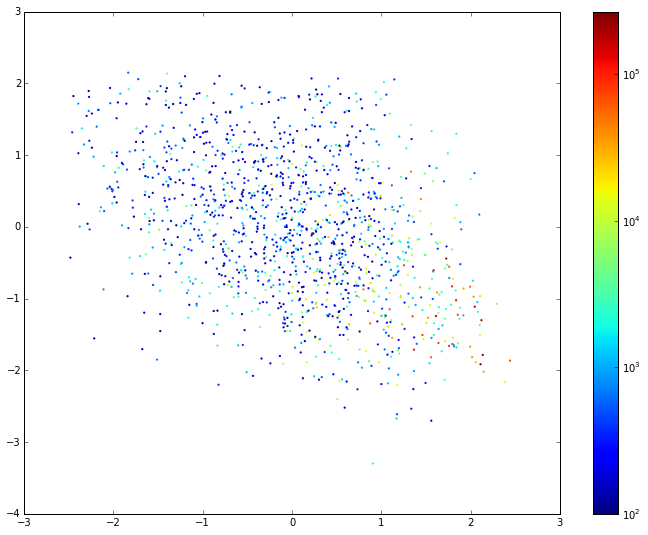

In [38]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(1,1,1)
scat = ax.scatter(s1_2, s2_3, c=descFreq, s=5, edgecolor='', norm=pltColors.LogNorm())
cbar = fig.colorbar(scat, ax=ax)
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

In [39]:
print sorted(descList, key=lambda w: s1_1[descId[w]], reverse=False)[:10]
print sorted(descList, key=lambda w: s1_1[descId[w]], reverse=True)[:10]

['revolving', 'merry', 'carousel', 'confessional', 'martial', 'retirement', 'rafting', 'veterinarian', 'nursing', 'raft']
['man', 'person', 'picture', 'laser', 'none', 'diagnostic', 'viewpoint', 'human', 'people', 'many']


In [40]:
print sorted(descList, key=lambda w: s1_2[descId[w]], reverse=False)[:10]
print sorted(descList, key=lambda w: s1_2[descId[w]], reverse=True)[:10]

['retirement', 'revolving', 'beehive', 'confessional', 'merry', 'nursing', 'martial', 'carousel', 'dentist', 'veterinarian']
['place', 'area', 'view', 'people', 'building', 'hall', 'house', 'wall', 'man', 'open']


In [41]:
print sorted(descList, key=lambda w: s2_3[descId[w]], reverse=False)[:10]
print sorted(descList, key=lambda w: s2_3[descId[w]], reverse=True)[:10]

['s', 'one', 'new', 'not', 'two', 'time', 'school', 'over', 'up', 'city']
['pantry', 'escalator', 'stairwell', 'tailoring', 'agri', 'mountainside', 'racecar', 'greenery', 'restroom', 'treehouse']


In [42]:
evalScore = [a + b for a, b in zip(s1_1, s2_3)]
print sorted(descList, key=lambda w: evalScore[descId[w]], reverse=False)[:10]
print sorted(descList, key=lambda w: evalScore[descId[w]], reverse=True)[:10]

['age', 'world', 'football', 'election', 'go', 'march', 'magazine', 'life', 'both', 'under']
['sed', 'viewpoint', 'restroom', 'diagnostic', 'roadside', 'stonewall', 'hanger', 'spaceship', 'bazar', 'rom']


In [43]:
evalScore = [a + b for a, b in zip(s1_2, s2_3)]
print sorted(descList, key=lambda w: evalScore[descId[w]], reverse=False)[:10]
print sorted(descList, key=lambda w: evalScore[descId[w]], reverse=True)[:10]

['election', 'march', 'age', 'world', 'winner', 'non', 'retirement', 'go', 'past', 'magazine']
['greenery', 'roadside', 'restroom', 'sed', 'bungalow', 'woodhouse', 'diagnostic', 'seashore', 'scenery', 'mahal']


In [24]:
# # load json taxonomy tree
# taxoTreeFile = 'model/taxoTree_2000_0.pickle.gz'
# import gzip
# import pickle
# with gzip.open(taxoTreeFile) as fin:
#     taxoTreeNodes = pickle.load(fin)
# print taxoTreeNodes[0][0]
# taxoTreeLabels = set(t[0] for t in taxoTreeNodes if len(t[2]) > 0)